Data Cleaning and checking not necessary here (my data set) pre-clean/checked

## Build and Train Neural Network Model

### Libaray and data import

Please ensure that the following libraries have been installed.

In [1]:
# Import libraries (Please make sure all packages are installed)
import numpy as np
import pandas as pd
import math
import sklearn
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import unittest

from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

# Ensure repeatibility
tf.random.set_seed(0)

In [11]:
# Current directory
current_directory = os.getcwd()

# Get training Data (same directory)
df = pd.read_csv(current_directory + "/BSM_result_training.csv")

# Reduce the size of the set and speed up the calculation (for illustration purpose)
df = df[0:1001]

In [12]:
# Create variables for training and validation data.
x_train_full = df.loc[:, df.columns != "Call"] # Train Data Features
y_train_full = df.loc[:,"Call"] # Train Data Target

# 10% Validation Data and 90% Train Data Split
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size = 0.1, random_state = 0) 

# Combine the train features and target for later analysis
train_set = pd.concat( [x_train, y_train], axis = 1)

### Data Analysis

In [13]:
# Check the data information and data type especially.
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 909 to 684
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Stock          900 non-null    float64
 1   Strike         900 non-null    float64
 2   Volatiltiy     900 non-null    float64
 3   Interest Rate  900 non-null    float64
 4   Dividend       900 non-null    float64
 5   Time           900 non-null    float64
 6   Call           900 non-null    float64
dtypes: float64(7)
memory usage: 56.2 KB


In [14]:
# Check the train data statistical summary.
train_set.describe()

,Stock,Strike,Volatiltiy,Interest Rate,Dividend,Time,Call
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,148.350448,146.909198,0.294380,0.057106,0.004686,1.963971,36.118817
std,30.763936,30.445474,0.060042,0.030050,0.002998,0.607097,25.022617
min,100.000000,100.000000,0.200000,0.010000,0.000000,1.000000,0.055854
25%,122.318169,120.782739,0.239672,0.031098,0.002104,1.402577,13.749149
50%,150.526409,145.452627,0.295018,0.056519,0.004683,2.009748,32.578978
75%,175.512823,174.008171,0.346247,0.083890,0.007175,2.470015,52.722594
max,199.796095,199.916912,0.399809,0.109915,0.010000,2.999036,106.991681


In [17]:
# Standardise the features with StandardScaler()
standardscaler = StandardScaler()
x_train_standard = pd.DataFrame(standardscaler.fit_transform(x_train), columns = x_train.columns)  # Standardise the train data
x_valid_standard = pd.DataFrame(standardscaler.transform(x_valid), columns = x_valid.columns) # Standardise the validation data using parameters from train data transformation

# Rename the train and validation target index to correspond to the index created using standardised train and validation data.
y_train.index = x_train_standard.index
y_valid.index = x_valid_standard.index

<Figure size 360x360 with 0 Axes>

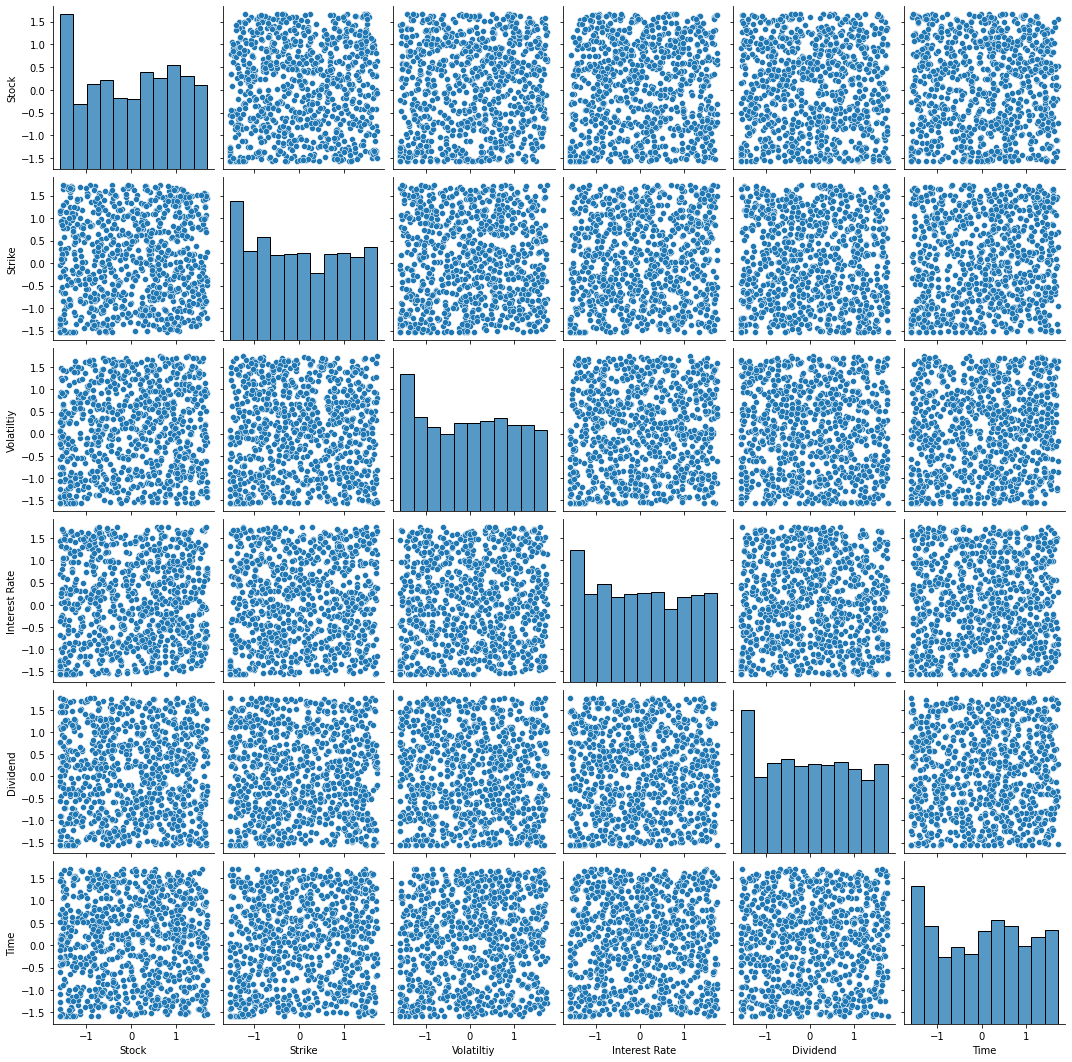

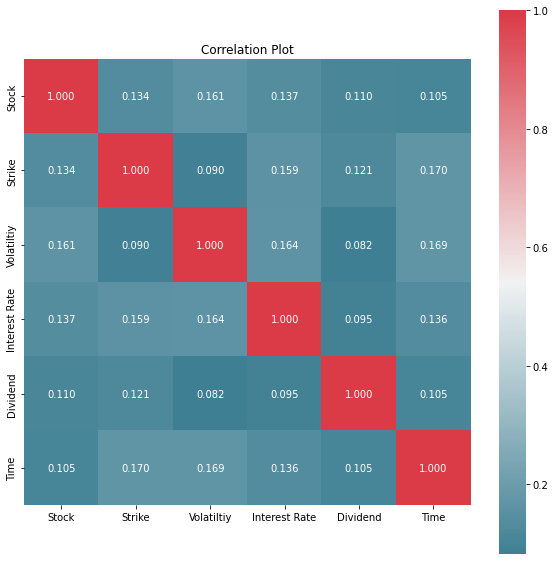

                  Stock    Strike  Volatiltiy  Interest Rate  Dividend  \
Stock          1.000000  0.134060    0.161387       0.137076  0.109604   
Strike         0.134060  1.000000    0.089569       0.159013  0.120753   
Volatiltiy     0.161387  0.089569    1.000000       0.163706  0.082355   
Interest Rate  0.137076  0.159013    0.163706       1.000000  0.094536   
Dividend       0.109604  0.120753    0.082355       0.094536  1.000000   
Time           0.105241  0.170468    0.169430       0.135545  0.104546   

                   Time  
Stock          0.105241  
Strike         0.170468  
Volatiltiy     0.169430  
Interest Rate  0.135545  
Dividend       0.104546  
Time           1.000000  


In [18]:
# Correlation plot
plt.figure(figsize = (5, 5))
sns.pairplot(x_train_standard)
plt.show()

corr = x_train_standard.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, annot = True, fmt = '.3f')
plt.title("Correlation Plot")
plt.show()
print(corr)

### Neural Network Model Training

In [19]:
# Define the base model function for Fine-Tuning Hyperparameters
def base_model(n_hidden = 1, n_neurons = 30, learning_rate = 3e-3, input_shape=[ x_train_standard.shape[1] ]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1, activation="linear"))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# KerasClassifier() for Classification
keras_classification = KerasClassifier(base_model)

# Different hyparameters for fine-tuning
param_distribs = {
    "n_hidden": [0, 1, 2, 3, 4, 5, 6],
    "n_neurons": np.arange(0, 30).tolist(),
}

# Fine-Tuning Hyperparameters
rnd_search_cv = RandomizedSearchCV(keras_classification, param_distribs, n_iter = 10, cv = 10, verbose = 2)
rnd_search_cv.fit(x_train_standard, y_train, epochs = 100, validation_data = (x_valid_standard, y_valid),
                  callbacks = [keras.callbacks.EarlyStopping(patience = 10)]) # callbacks

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if sys.path[0] == '':


26/26 [==============================] - 1s 9ms/step - loss: 218263.9062 - mae: 404.4632 - val_loss: 1803.6879 - val_mae: 35.3885
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218155.1875 - mae: 404.3418 - val_loss: 1790.2903 - val_mae: 35.2312
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217978.1719 - mae: 404.1535 - val_loss: 1767.1437 - val_mae: 34.9584
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217635.9062 - mae: 403.7926 - val_loss: 1720.2743 - val_mae: 34.4007
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216997.0156 - mae: 403.1056 - val_loss: 1639.0427 - val_mae: 33.4151
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 215881.2656 - mae: 401.9238 - val_loss: 1504.9825 - val_mae: 31.7220
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 213990.3438 - mae: 399.9010 - val_loss: 1303.0302 - val_mae: 29.0519
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217794.3906 - mae: 403.8800 - val_loss: 1725.4053 - val_mae: 34.1842
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216475.7969 - mae: 402.2323 - val_loss: 1570.2297 - val_mae: 31.8587
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 213597.1875 - mae: 398.7551 - val_loss: 1282.3792 - val_mae: 27.6498
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 207882.3750 - mae: 391.9886 - val_loss: 874.6702 - val_mae: 23.0961
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 197503.5781 - mae: 379.4899 - val_loss: 651.3826 - val_mae: 21.4880
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 179829.9844 - mae: 358.2966 - val_loss: 1846.3270 - val_mae: 36.5661
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 152859.3906 - mae: 325.2748 - val_loss: 7582.1221 - val_mae: 79.3323
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217672.4375 - mae: 403.7239 - val_loss: 1706.9432 - val_mae: 34.0168
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216145.7344 - mae: 401.8617 - val_loss: 1541.7286 - val_mae: 31.6231
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 212999.1094 - mae: 398.1038 - val_loss: 1263.3789 - val_mae: 28.3393
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 206865.4688 - mae: 391.0199 - val_loss: 909.7637 - val_mae: 23.8383
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 196542.5781 - mae: 378.7848 - val_loss: 834.0853 - val_mae: 22.5308
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 179570.6719 - mae: 359.0773 - val_loss: 2155.5076 - val_mae: 33.6609
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 154221.0625 - mae: 331.5872 - val_loss: 7887.7646 - val_mae: 69.1729
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218108.6094 - mae: 404.2773 - val_loss: 1777.8094 - val_mae: 35.0035
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217580.8125 - mae: 403.6463 - val_loss: 1714.9393 - val_mae: 34.1019
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 216399.3281 - mae: 402.2675 - val_loss: 1584.6223 - val_mae: 32.2190
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 213880.6719 - mae: 399.4417 - val_loss: 1345.7460 - val_mae: 28.8344
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 209171.3125 - mae: 394.0410 - val_loss: 992.9022 - val_mae: 23.8516
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 200580.4688 - mae: 384.4639 - val_loss: 654.9172 - val_mae: 20.4657
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 186324.5000 - mae: 368.4184 - val_loss: 895.9955 - val_mae: 24.2248
Epoch 8/100
26/26 [==

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 10ms/step - loss: 218119.9531 - mae: 404.2664 - val_loss: 1779.4049 - val_mae: 34.9841
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217605.3906 - mae: 403.5819 - val_loss: 1721.0641 - val_mae: 34.0527
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 216518.0625 - mae: 402.1688 - val_loss: 1611.6204 - val_mae: 32.2906
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 214459.1875 - mae: 399.5259 - val_loss: 1433.8285 - val_mae: 29.4799
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 210867.7969 - mae: 394.8948 - val_loss: 1178.2518 - val_mae: 26.4318
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 204597.9062 - mae: 386.8042 - val_loss: 939.3550 - val_mae: 24.0127
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 193936.8750 - mae: 373.4527 - val_loss: 1099.1836 - val_mae: 27.8771
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218183.8594 - mae: 404.3680 - val_loss: 1789.2269 - val_mae: 35.1791
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217783.1875 - mae: 403.8974 - val_loss: 1739.7811 - val_mae: 34.4977
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 216864.8906 - mae: 402.8247 - val_loss: 1636.8387 - val_mae: 33.0652
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 214940.0938 - mae: 400.6508 - val_loss: 1451.2250 - val_mae: 30.3432
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 211465.2500 - mae: 396.6122 - val_loss: 1171.0332 - val_mae: 25.8127
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 205556.9219 - mae: 389.7738 - val_loss: 846.8686 - val_mae: 21.4631
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 195804.6875 - mae: 378.6380 - val_loss: 671.2457 - val_mae: 20.8027
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 10ms/step - loss: 218183.9219 - mae: 404.3591 - val_loss: 1790.4597 - val_mae: 35.1760
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217903.5000 - mae: 404.0106 - val_loss: 1754.4666 - val_mae: 34.6569
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217355.2656 - mae: 403.3482 - val_loss: 1685.4341 - val_mae: 33.6782
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216328.7344 - mae: 402.1400 - val_loss: 1561.1760 - val_mae: 31.8934
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 214549.6875 - mae: 400.0240 - val_loss: 1366.9805 - val_mae: 29.2605
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 211542.3594 - mae: 396.5172 - val_loss: 1080.8256 - val_mae: 25.5724
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 206644.3906 - mae: 390.9183 - val_loss: 750.5060 - val_mae: 21.5027
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


Epoch 1/100
26/26 [==============================] - 1s 9ms/step - loss: 217827.6094 - mae: 403.9669 - val_loss: 1724.0736 - val_mae: 34.3097
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216444.4688 - mae: 402.3741 - val_loss: 1561.0024 - val_mae: 31.9950
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 213439.0938 - mae: 398.9575 - val_loss: 1270.5602 - val_mae: 27.6739
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 207666.6406 - mae: 392.4456 - val_loss: 864.7164 - val_mae: 22.5202
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 197891.5000 - mae: 381.2567 - val_loss: 558.7535 - val_mae: 19.8288
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 181842.5469 - mae: 362.6333 - val_loss: 1105.8939 - val_mae: 26.8358
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 157740.7969 - mae: 334.2616 - val_loss: 4460.5215 - val_mae: 58.0364
Epoch 8/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218200.5312 - mae: 404.3811 - val_loss: 1792.5829 - val_mae: 35.2139
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217915.6094 - mae: 404.0016 - val_loss: 1755.7772 - val_mae: 34.6548
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 217299.3594 - mae: 403.1755 - val_loss: 1674.8925 - val_mae: 33.4267
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216008.9844 - mae: 401.4710 - val_loss: 1519.0739 - val_mae: 31.0484
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 213527.2812 - mae: 398.2290 - val_loss: 1259.0204 - val_mae: 27.3946
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 208948.0156 - mae: 392.3362 - val_loss: 901.7549 - val_mae: 23.1823
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 200774.8125 - mae: 382.1201 - val_loss: 683.0214 - val_mae: 21.8030
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 10ms/step - loss: 218259.0625 - mae: 404.4661 - val_loss: 1800.6711 - val_mae: 35.3528
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 218094.1406 - mae: 404.2592 - val_loss: 1784.3112 - val_mae: 35.1052
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217854.4375 - mae: 403.9508 - val_loss: 1758.3326 - val_mae: 34.7054
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217425.7969 - mae: 403.3923 - val_loss: 1712.7274 - val_mae: 33.9734
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216643.1875 - mae: 402.3297 - val_loss: 1634.4799 - val_mae: 32.7056
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 215257.0312 - mae: 400.4673 - val_loss: 1508.5873 - val_mae: 30.6450
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 212840.0625 - mae: 397.2644 - val_loss: 1327.5601 - val_mae: 27.8137
Epoch 8/100
26/26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 219142.5938 - mae: 405.6535 - val_loss: 1868.5439 - val_mae: 36.4328
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218991.2031 - mae: 405.4750 - val_loss: 1857.9597 - val_mae: 36.2856
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 218861.3125 - mae: 405.3199 - val_loss: 1848.2638 - val_mae: 36.1475
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 218743.1562 - mae: 405.1756 - val_loss: 1839.4625 - val_mae: 36.0201
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 218635.5625 - mae: 405.0413 - val_loss: 1831.3035 - val_mae: 35.9004
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 218535.1094 - mae: 404.9158 - val_loss: 1823.7338 - val_mae: 35.7868
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 218444.5781 - mae: 404.7986 - val_loss: 1816.9629 - val_mae: 35.6828
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 219012.7031 - mae: 405.2462 - val_loss: 1863.3461 - val_mae: 36.0772
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 218835.8594 - mae: 405.0616 - val_loss: 1849.6842 - val_mae: 35.9162
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 218676.7344 - mae: 404.8969 - val_loss: 1836.8502 - val_mae: 35.7647
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 218525.9531 - mae: 404.7417 - val_loss: 1824.6202 - val_mae: 35.6194
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 218382.9375 - mae: 404.5923 - val_loss: 1812.6667 - val_mae: 35.4773
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 218243.1875 - mae: 404.4471 - val_loss: 1801.1366 - val_mae: 35.3394
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 218107.9688 - mae: 404.3075 - val_loss: 1790.4395 - val_mae: 35.2100
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 218451.8906 - mae: 404.6622 - val_loss: 1804.6835 - val_mae: 35.5149
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 218309.8438 - mae: 404.5011 - val_loss: 1793.0580 - val_mae: 35.3680
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218177.7188 - mae: 404.3529 - val_loss: 1781.4467 - val_mae: 35.2209
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 218044.1094 - mae: 404.2039 - val_loss: 1769.7780 - val_mae: 35.0726
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 217913.0000 - mae: 404.0558 - val_loss: 1758.1949 - val_mae: 34.9260
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217780.0312 - mae: 403.9072 - val_loss: 1746.3800 - val_mae: 34.7766
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217642.7500 - mae: 403.7557 - val_loss: 1734.6510 - val_mae: 34.6283
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218554.6406 - mae: 404.6543 - val_loss: 1841.5522 - val_mae: 35.6101
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218379.3125 - mae: 404.4625 - val_loss: 1827.7466 - val_mae: 35.4425
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218222.6406 - mae: 404.2917 - val_loss: 1814.6233 - val_mae: 35.2812
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 218066.5938 - mae: 404.1220 - val_loss: 1801.4929 - val_mae: 35.1175
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217915.4219 - mae: 403.9532 - val_loss: 1788.5916 - val_mae: 34.9557
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217765.3906 - mae: 403.7867 - val_loss: 1776.0562 - val_mae: 34.7971
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217618.6875 - mae: 403.6235 - val_loss: 1764.2181 - val_mae: 34.6443
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218336.5000 - mae: 404.2718 - val_loss: 1818.3179 - val_mae: 35.2611
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218171.8281 - mae: 404.0702 - val_loss: 1804.3939 - val_mae: 35.0710
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218016.6719 - mae: 403.8806 - val_loss: 1790.0934 - val_mae: 34.8737
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217856.0000 - mae: 403.6874 - val_loss: 1775.4149 - val_mae: 34.6731
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217693.7500 - mae: 403.4909 - val_loss: 1760.4954 - val_mae: 34.4678
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217530.4062 - mae: 403.2906 - val_loss: 1745.4779 - val_mae: 34.2629
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 217359.6250 - mae: 403.0883 - val_loss: 1729.8334 - val_mae: 34.0485
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218148.2656 - mae: 404.2068 - val_loss: 1797.5370 - val_mae: 35.1676
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218058.8906 - mae: 404.0796 - val_loss: 1790.7380 - val_mae: 35.0573
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 217971.2031 - mae: 403.9588 - val_loss: 1783.6492 - val_mae: 34.9428
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217876.8125 - mae: 403.8310 - val_loss: 1776.0167 - val_mae: 34.8207
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217777.4844 - mae: 403.6966 - val_loss: 1767.8688 - val_mae: 34.6917
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217671.9531 - mae: 403.5546 - val_loss: 1759.3997 - val_mae: 34.5588
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217559.3281 - mae: 403.4090 - val_loss: 1750.5453 - val_mae: 34.4222
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218243.1562 - mae: 404.4606 - val_loss: 1789.7371 - val_mae: 35.2104
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218060.2500 - mae: 404.2675 - val_loss: 1775.0808 - val_mae: 35.0359
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217890.0312 - mae: 404.0896 - val_loss: 1760.3636 - val_mae: 34.8613
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217717.6719 - mae: 403.9105 - val_loss: 1745.1488 - val_mae: 34.6813
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217545.8906 - mae: 403.7315 - val_loss: 1730.3876 - val_mae: 34.5052
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217374.1250 - mae: 403.5527 - val_loss: 1715.5031 - val_mae: 34.3290
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217198.7031 - mae: 403.3739 - val_loss: 1700.8489 - val_mae: 34.1542
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 12ms/step - loss: 217599.1875 - mae: 403.8520 - val_loss: 1743.1504 - val_mae: 34.7630
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217428.1250 - mae: 403.6829 - val_loss: 1729.6487 - val_mae: 34.6150
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217262.0000 - mae: 403.5218 - val_loss: 1716.1908 - val_mae: 34.4672
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 217087.0156 - mae: 403.3531 - val_loss: 1701.6030 - val_mae: 34.3080
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216905.5781 - mae: 403.1784 - val_loss: 1686.5242 - val_mae: 34.1429
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 216714.8594 - mae: 402.9964 - val_loss: 1670.9622 - val_mae: 33.9734
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 216516.1406 - mae: 402.8082 - val_loss: 1655.3494 - val_mae: 33.8024
Epoch 8/100
26/26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217480.8750 - mae: 403.5609 - val_loss: 1724.5155 - val_mae: 34.3633
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217278.2656 - mae: 403.3550 - val_loss: 1708.8114 - val_mae: 34.1744
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217083.9062 - mae: 403.1581 - val_loss: 1693.3401 - val_mae: 33.9861
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216881.8906 - mae: 402.9547 - val_loss: 1676.6891 - val_mae: 33.7851
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 216673.4219 - mae: 402.7440 - val_loss: 1659.6516 - val_mae: 33.5804
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 216455.7188 - mae: 402.5266 - val_loss: 1641.6420 - val_mae: 33.3653
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 216227.7500 - mae: 402.3015 - val_loss: 1623.6429 - val_mae: 33.1494
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217902.4062 - mae: 404.2184 - val_loss: 1772.0354 - val_mae: 35.1288
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217733.4688 - mae: 404.0170 - val_loss: 1756.3387 - val_mae: 34.9305
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217574.5000 - mae: 403.8279 - val_loss: 1741.2979 - val_mae: 34.7363
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 217408.6719 - mae: 403.6350 - val_loss: 1725.0675 - val_mae: 34.5264
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 217239.2500 - mae: 403.4348 - val_loss: 1709.0254 - val_mae: 34.3203
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217062.8906 - mae: 403.2305 - val_loss: 1692.2180 - val_mae: 34.1038
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 216881.7031 - mae: 403.0228 - val_loss: 1676.4021 - val_mae: 33.8987
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217904.7656 - mae: 404.0260 - val_loss: 1756.0326 - val_mae: 34.7052
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217468.3906 - mae: 403.5006 - val_loss: 1709.8466 - val_mae: 34.0828
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 216897.2188 - mae: 402.8295 - val_loss: 1648.7137 - val_mae: 33.2740
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216156.0469 - mae: 401.9681 - val_loss: 1572.1516 - val_mae: 32.2419
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 215197.2969 - mae: 400.8621 - val_loss: 1474.3636 - val_mae: 30.8926
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 213961.4844 - mae: 399.4550 - val_loss: 1355.7750 - val_mae: 29.2425
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 212390.8281 - mae: 397.6712 - val_loss: 1216.4426 - val_mae: 27.2657
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218224.2500 - mae: 404.4048 - val_loss: 1798.6781 - val_mae: 35.3032
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218121.7188 - mae: 404.2701 - val_loss: 1788.2495 - val_mae: 35.1542
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 217997.1094 - mae: 404.1101 - val_loss: 1774.6200 - val_mae: 34.9640
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217828.1250 - mae: 403.8915 - val_loss: 1756.3496 - val_mae: 34.7051
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217600.2031 - mae: 403.5854 - val_loss: 1732.0973 - val_mae: 34.3497
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217300.0156 - mae: 403.1884 - val_loss: 1701.0579 - val_mae: 33.8885
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 216920.6250 - mae: 402.6869 - val_loss: 1663.2993 - val_mae: 33.3223
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218353.9688 - mae: 404.5396 - val_loss: 1804.7643 - val_mae: 35.3793
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 218192.6250 - mae: 404.3410 - val_loss: 1793.3306 - val_mae: 35.2168
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218057.0000 - mae: 404.1733 - val_loss: 1781.2574 - val_mae: 35.0434
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217912.9062 - mae: 403.9930 - val_loss: 1767.3783 - val_mae: 34.8462
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217744.1562 - mae: 403.7780 - val_loss: 1750.2687 - val_mae: 34.6072
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217536.8438 - mae: 403.5174 - val_loss: 1728.9508 - val_mae: 34.3112
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 217281.4375 - mae: 403.2008 - val_loss: 1703.6283 - val_mae: 33.9586
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218105.8594 - mae: 404.2959 - val_loss: 1783.9884 - val_mae: 35.1331
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217872.4688 - mae: 404.0312 - val_loss: 1761.9456 - val_mae: 34.8297
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217588.1094 - mae: 403.7032 - val_loss: 1734.7638 - val_mae: 34.4491
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217234.9375 - mae: 403.3078 - val_loss: 1702.4741 - val_mae: 33.9994
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 216826.9062 - mae: 402.8400 - val_loss: 1665.1157 - val_mae: 33.4777
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 216332.7188 - mae: 402.2908 - val_loss: 1621.0725 - val_mae: 32.8581
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 215725.9062 - mae: 401.6171 - val_loss: 1568.1078 - val_mae: 32.1093
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218360.9844 - mae: 404.5666 - val_loss: 1810.0665 - val_mae: 35.4592
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218262.9531 - mae: 404.4438 - val_loss: 1803.6656 - val_mae: 35.3730
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218189.9688 - mae: 404.3563 - val_loss: 1798.1586 - val_mae: 35.2967
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 218123.9688 - mae: 404.2747 - val_loss: 1792.7299 - val_mae: 35.2191
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 218054.8594 - mae: 404.1853 - val_loss: 1786.4900 - val_mae: 35.1255
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217972.1875 - mae: 404.0736 - val_loss: 1778.3781 - val_mae: 35.0044
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217862.8281 - mae: 403.9293 - val_loss: 1768.3416 - val_mae: 34.8499
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218289.2812 - mae: 404.5254 - val_loss: 1804.0427 - val_mae: 35.4016
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218166.3594 - mae: 404.3424 - val_loss: 1793.5748 - val_mae: 35.2286
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218026.7500 - mae: 404.1467 - val_loss: 1779.7404 - val_mae: 35.0102
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217826.1719 - mae: 403.8699 - val_loss: 1758.6075 - val_mae: 34.6769
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217533.9062 - mae: 403.4600 - val_loss: 1730.7938 - val_mae: 34.2472
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217174.3750 - mae: 402.9696 - val_loss: 1698.9595 - val_mae: 33.7570
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 216736.4531 - mae: 402.4029 - val_loss: 1660.9492 - val_mae: 33.1678
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217920.6719 - mae: 404.0562 - val_loss: 1765.3793 - val_mae: 34.8821
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217601.5781 - mae: 403.6781 - val_loss: 1737.9282 - val_mae: 34.5157
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217206.1094 - mae: 403.2185 - val_loss: 1702.8259 - val_mae: 34.0408
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216675.7969 - mae: 402.6111 - val_loss: 1656.6055 - val_mae: 33.4080
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 215982.4219 - mae: 401.8119 - val_loss: 1597.1937 - val_mae: 32.5770
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 215071.5312 - mae: 400.7643 - val_loss: 1523.1798 - val_mae: 31.5538
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 213858.7031 - mae: 399.4146 - val_loss: 1430.0422 - val_mae: 30.2498
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218139.9531 - mae: 404.2773 - val_loss: 1790.3245 - val_mae: 35.1508
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218008.6094 - mae: 404.1057 - val_loss: 1777.8229 - val_mae: 34.9628
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 217853.7812 - mae: 403.9042 - val_loss: 1762.1689 - val_mae: 34.7287
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217659.7969 - mae: 403.6560 - val_loss: 1742.7542 - val_mae: 34.4403
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217420.5469 - mae: 403.3500 - val_loss: 1719.0433 - val_mae: 34.0884
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217124.3906 - mae: 402.9742 - val_loss: 1690.3108 - val_mae: 33.6622
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 216756.5625 - mae: 402.5175 - val_loss: 1655.7892 - val_mae: 33.1459
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218243.3750 - mae: 404.4375 - val_loss: 1802.0389 - val_mae: 35.3637
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 218142.0312 - mae: 404.3178 - val_loss: 1790.5216 - val_mae: 35.2107
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217973.0625 - mae: 404.1273 - val_loss: 1773.2343 - val_mae: 34.9814
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217695.8438 - mae: 403.8213 - val_loss: 1746.9238 - val_mae: 34.6274
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217274.6250 - mae: 403.3409 - val_loss: 1710.1790 - val_mae: 34.1156
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 216737.3281 - mae: 402.7154 - val_loss: 1665.0754 - val_mae: 33.4719
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 216056.8750 - mae: 401.9377 - val_loss: 1609.6506 - val_mae: 32.6584
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


Epoch 1/100
26/26 [==============================] - 2s 23ms/step - loss: 218265.6250 - mae: 404.4592 - val_loss: 1800.0764 - val_mae: 35.3402
Epoch 2/100
26/26 [==============================] - 0s 6ms/step - loss: 218107.0469 - mae: 404.2733 - val_loss: 1784.9301 - val_mae: 35.1399
Epoch 3/100
26/26 [==============================] - 0s 10ms/step - loss: 217920.7656 - mae: 404.0531 - val_loss: 1766.5936 - val_mae: 34.8978
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 217686.8594 - mae: 403.7836 - val_loss: 1744.0201 - val_mae: 34.5987
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 217406.4062 - mae: 403.4545 - val_loss: 1717.2683 - val_mae: 34.2462
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 217063.9844 - mae: 403.0599 - val_loss: 1684.3796 - val_mae: 33.8088
Epoch 7/100
26/26 [==============================] - 0s 7ms/step - loss: 216642.0000 - mae: 402.5813 - val_loss: 1646.6847 - val_mae: 33.3016
Epoc

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


Epoch 1/100
26/26 [==============================] - 1s 7ms/step - loss: 218226.1719 - mae: 404.4879 - val_loss: 1784.0649 - val_mae: 35.2433
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218184.4219 - mae: 404.4611 - val_loss: 1780.7679 - val_mae: 35.2178
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 218145.6719 - mae: 404.4351 - val_loss: 1777.5023 - val_mae: 35.1927
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 218107.2812 - mae: 404.4099 - val_loss: 1774.3405 - val_mae: 35.1677
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 218069.8594 - mae: 404.3849 - val_loss: 1771.0664 - val_mae: 35.1425
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 218031.9062 - mae: 404.3590 - val_loss: 1767.8033 - val_mae: 35.1168
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217993.5781 - mae: 404.3344 - val_loss: 1764.5254 - val_mae: 35.0916
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218627.6094 - mae: 404.4894 - val_loss: 1829.0458 - val_mae: 35.4105
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218586.0312 - mae: 404.4619 - val_loss: 1825.6932 - val_mae: 35.3839
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218546.8438 - mae: 404.4344 - val_loss: 1822.3138 - val_mae: 35.3574
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 218507.8906 - mae: 404.4080 - val_loss: 1819.0138 - val_mae: 35.3311
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 218469.7656 - mae: 404.3822 - val_loss: 1815.6533 - val_mae: 35.3046
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 218431.4219 - mae: 404.3559 - val_loss: 1812.2573 - val_mae: 35.2774
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 218392.6250 - mae: 404.3303 - val_loss: 1808.9574 - val_mae: 35.2510
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 218328.7188 - mae: 404.5084 - val_loss: 1810.5040 - val_mae: 35.5262
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218287.3750 - mae: 404.4819 - val_loss: 1807.1226 - val_mae: 35.5002
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 218248.2188 - mae: 404.4547 - val_loss: 1803.7645 - val_mae: 35.4745
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 218209.1250 - mae: 404.4285 - val_loss: 1800.4496 - val_mae: 35.4486
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 218171.5000 - mae: 404.4033 - val_loss: 1797.1292 - val_mae: 35.4229
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 218133.6250 - mae: 404.3776 - val_loss: 1793.7563 - val_mae: 35.3965
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 218094.9531 - mae: 404.3519 - val_loss: 1790.4392 - val_mae: 35.3705
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 217954.2344 - mae: 404.4912 - val_loss: 1771.6167 - val_mae: 35.4593
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217911.9062 - mae: 404.4635 - val_loss: 1768.3188 - val_mae: 35.4339
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 217872.5469 - mae: 404.4365 - val_loss: 1765.1437 - val_mae: 35.4088
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217832.9219 - mae: 404.4098 - val_loss: 1761.9623 - val_mae: 35.3836
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217794.7188 - mae: 404.3839 - val_loss: 1758.7986 - val_mae: 35.3585
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217756.0938 - mae: 404.3576 - val_loss: 1755.5956 - val_mae: 35.3333
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217716.8750 - mae: 404.3313 - val_loss: 1752.4406 - val_mae: 35.3079
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 217896.7500 - mae: 404.4846 - val_loss: 1782.1217 - val_mae: 35.5127
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217855.1250 - mae: 404.4575 - val_loss: 1778.7343 - val_mae: 35.4870
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217816.7344 - mae: 404.4317 - val_loss: 1775.5625 - val_mae: 35.4618
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217778.5625 - mae: 404.4062 - val_loss: 1772.2986 - val_mae: 35.4362
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217741.0156 - mae: 404.3808 - val_loss: 1769.1040 - val_mae: 35.4109
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217703.8438 - mae: 404.3561 - val_loss: 1765.9315 - val_mae: 35.3856
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217665.7188 - mae: 404.3302 - val_loss: 1762.7087 - val_mae: 35.3599
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 6ms/step - loss: 218522.1875 - mae: 404.4943 - val_loss: 1817.2205 - val_mae: 35.3511
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218479.9219 - mae: 404.4658 - val_loss: 1813.7570 - val_mae: 35.3246
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 218441.1250 - mae: 404.4394 - val_loss: 1810.5082 - val_mae: 35.2991
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 218402.0312 - mae: 404.4127 - val_loss: 1807.1603 - val_mae: 35.2728
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 218364.1250 - mae: 404.3869 - val_loss: 1803.9717 - val_mae: 35.2476
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 218326.1562 - mae: 404.3617 - val_loss: 1800.6879 - val_mae: 35.2216
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 218287.0781 - mae: 404.3346 - val_loss: 1797.3442 - val_mae: 35.1950
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 218494.3594 - mae: 404.4847 - val_loss: 1803.5322 - val_mae: 35.2393
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 218452.2344 - mae: 404.4569 - val_loss: 1800.1292 - val_mae: 35.2136
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218413.0156 - mae: 404.4305 - val_loss: 1796.8784 - val_mae: 35.1885
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 218373.8438 - mae: 404.4041 - val_loss: 1793.4958 - val_mae: 35.1628
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 218335.2031 - mae: 404.3789 - val_loss: 1790.2585 - val_mae: 35.1378
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 218296.5938 - mae: 404.3538 - val_loss: 1786.9492 - val_mae: 35.1123
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 218257.2969 - mae: 404.3271 - val_loss: 1783.6903 - val_mae: 35.0869
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 6ms/step - loss: 218080.8438 - mae: 404.4708 - val_loss: 1807.0580 - val_mae: 35.6199
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 218038.4531 - mae: 404.4425 - val_loss: 1803.6760 - val_mae: 35.5942
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 217999.0781 - mae: 404.4156 - val_loss: 1800.4481 - val_mae: 35.5691
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217959.6250 - mae: 404.3889 - val_loss: 1797.1162 - val_mae: 35.5435
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217920.4219 - mae: 404.3632 - val_loss: 1793.8680 - val_mae: 35.5184
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217881.2188 - mae: 404.3377 - val_loss: 1790.5956 - val_mae: 35.4929
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217841.9531 - mae: 404.3110 - val_loss: 1787.3710 - val_mae: 35.4678
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 218166.1094 - mae: 404.4683 - val_loss: 1818.0254 - val_mae: 35.5819
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 218124.2344 - mae: 404.4405 - val_loss: 1814.6329 - val_mae: 35.5548
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218084.9531 - mae: 404.4138 - val_loss: 1811.4502 - val_mae: 35.5289
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 218046.0625 - mae: 404.3877 - val_loss: 1808.1829 - val_mae: 35.5024
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 218007.4531 - mae: 404.3621 - val_loss: 1804.9849 - val_mae: 35.4765
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217968.4531 - mae: 404.3367 - val_loss: 1801.6494 - val_mae: 35.4501
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217928.8125 - mae: 404.3102 - val_loss: 1798.4387 - val_mae: 35.4249
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 218778.1406 - mae: 404.4927 - val_loss: 1832.6008 - val_mae: 35.3277
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218736.0938 - mae: 404.4638 - val_loss: 1829.1309 - val_mae: 35.3013
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218697.0000 - mae: 404.4367 - val_loss: 1825.8453 - val_mae: 35.2758
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 218657.9219 - mae: 404.4099 - val_loss: 1822.4448 - val_mae: 35.2496
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 218619.1406 - mae: 404.3836 - val_loss: 1819.1420 - val_mae: 35.2244
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 218579.6719 - mae: 404.3576 - val_loss: 1815.6543 - val_mae: 35.1982
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 218540.0938 - mae: 404.3309 - val_loss: 1812.3717 - val_mae: 35.1729
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217802.6719 - mae: 403.9556 - val_loss: 1761.0093 - val_mae: 34.7661
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217514.0938 - mae: 403.6252 - val_loss: 1738.5880 - val_mae: 34.4600
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217236.3594 - mae: 403.3127 - val_loss: 1715.6324 - val_mae: 34.1514
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216946.0000 - mae: 402.9903 - val_loss: 1691.6184 - val_mae: 33.8308
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216640.2188 - mae: 402.6539 - val_loss: 1665.5280 - val_mae: 33.4901
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 216302.6406 - mae: 402.2934 - val_loss: 1637.1479 - val_mae: 33.1220
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 215938.9062 - mae: 401.9092 - val_loss: 1607.4368 - val_mae: 32.7388
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218311.3125 - mae: 404.4917 - val_loss: 1796.6775 - val_mae: 35.2418
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 218009.7188 - mae: 404.1270 - val_loss: 1771.4368 - val_mae: 34.8942
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217728.7188 - mae: 403.7940 - val_loss: 1745.8374 - val_mae: 34.5444
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217441.2812 - mae: 403.4566 - val_loss: 1719.7047 - val_mae: 34.1894
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217149.7812 - mae: 403.1140 - val_loss: 1693.2240 - val_mae: 33.8291
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 216850.8906 - mae: 402.7669 - val_loss: 1666.3457 - val_mae: 33.4635
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 216543.4062 - mae: 402.4160 - val_loss: 1640.0199 - val_mae: 33.1061
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 218110.5625 - mae: 404.3624 - val_loss: 1789.1399 - val_mae: 35.2202
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217805.8594 - mae: 403.9809 - val_loss: 1764.1632 - val_mae: 34.8683
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217513.7031 - mae: 403.6244 - val_loss: 1738.2233 - val_mae: 34.5066
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217206.8125 - mae: 403.2573 - val_loss: 1711.2594 - val_mae: 34.1392
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216890.8594 - mae: 402.8810 - val_loss: 1683.2051 - val_mae: 33.7595
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 216559.3438 - mae: 402.4928 - val_loss: 1654.4863 - val_mae: 33.3707
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 216208.7969 - mae: 402.0873 - val_loss: 1624.8986 - val_mae: 32.9679
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218363.7500 - mae: 404.6913 - val_loss: 1802.3115 - val_mae: 35.4674
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218091.4375 - mae: 404.3625 - val_loss: 1781.2444 - val_mae: 35.1708
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217832.5938 - mae: 404.0559 - val_loss: 1760.1454 - val_mae: 34.8710
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 217565.2812 - mae: 403.7464 - val_loss: 1738.3258 - val_mae: 34.5674
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217290.8906 - mae: 403.4259 - val_loss: 1715.4896 - val_mae: 34.2580
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 217000.9688 - mae: 403.0987 - val_loss: 1691.8644 - val_mae: 33.9403
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 216693.8438 - mae: 402.7571 - val_loss: 1667.3960 - val_mae: 33.6094
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217495.3906 - mae: 403.3523 - val_loss: 1722.3124 - val_mae: 34.1643
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 217102.1875 - mae: 402.9307 - val_loss: 1690.1019 - val_mae: 33.7768
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 216720.1719 - mae: 402.5275 - val_loss: 1657.2981 - val_mae: 33.3773
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216311.3906 - mae: 402.0996 - val_loss: 1621.9163 - val_mae: 32.9461
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 215880.8438 - mae: 401.6507 - val_loss: 1584.8088 - val_mae: 32.4905
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 215424.7344 - mae: 401.1751 - val_loss: 1546.5166 - val_mae: 32.0197
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 214931.3438 - mae: 400.6733 - val_loss: 1505.8734 - val_mae: 31.5169
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217440.9844 - mae: 403.3809 - val_loss: 1719.9214 - val_mae: 34.1573
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217113.6719 - mae: 402.9940 - val_loss: 1693.6948 - val_mae: 33.7968
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 216792.7500 - mae: 402.6205 - val_loss: 1666.9498 - val_mae: 33.4267
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216447.6719 - mae: 402.2287 - val_loss: 1638.0106 - val_mae: 33.0305
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216083.9688 - mae: 401.8157 - val_loss: 1607.7839 - val_mae: 32.6153
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 215694.4375 - mae: 401.3785 - val_loss: 1576.3107 - val_mae: 32.1863
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 215272.8125 - mae: 400.9207 - val_loss: 1542.7125 - val_mae: 31.7453
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218145.0625 - mae: 404.1321 - val_loss: 1766.0110 - val_mae: 34.7977
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217798.2812 - mae: 403.7563 - val_loss: 1736.8870 - val_mae: 34.4468
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 217473.1406 - mae: 403.4087 - val_loss: 1707.6187 - val_mae: 34.0938
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217135.5781 - mae: 403.0510 - val_loss: 1676.4878 - val_mae: 33.7174
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216787.8125 - mae: 402.6815 - val_loss: 1645.1622 - val_mae: 33.3386
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 216424.9062 - mae: 402.3004 - val_loss: 1611.8386 - val_mae: 32.9355
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 216041.5000 - mae: 401.9050 - val_loss: 1578.7473 - val_mae: 32.5333
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218062.9062 - mae: 404.2769 - val_loss: 1778.0166 - val_mae: 35.0186
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217676.7188 - mae: 403.8743 - val_loss: 1747.7002 - val_mae: 34.6548
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217314.5938 - mae: 403.4997 - val_loss: 1717.7999 - val_mae: 34.2923
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216942.8125 - mae: 403.1194 - val_loss: 1686.7477 - val_mae: 33.9150
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216560.6094 - mae: 402.7290 - val_loss: 1655.2979 - val_mae: 33.5321
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 216165.3125 - mae: 402.3291 - val_loss: 1623.3699 - val_mae: 33.1444
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 215756.3594 - mae: 401.9217 - val_loss: 1591.3607 - val_mae: 32.7535
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217583.8750 - mae: 403.5827 - val_loss: 1737.8306 - val_mae: 34.4331
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217254.9375 - mae: 403.1973 - val_loss: 1711.8784 - val_mae: 34.0777
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 216923.8281 - mae: 402.8191 - val_loss: 1684.8329 - val_mae: 33.7081
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216568.6875 - mae: 402.4201 - val_loss: 1655.1184 - val_mae: 33.3080
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216189.1562 - mae: 401.9971 - val_loss: 1623.9664 - val_mae: 32.8929
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 215785.1094 - mae: 401.5547 - val_loss: 1590.4542 - val_mae: 32.4496
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 215345.5156 - mae: 401.0845 - val_loss: 1555.7145 - val_mae: 31.9905
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 11ms/step - loss: 218122.8281 - mae: 404.3431 - val_loss: 1775.6110 - val_mae: 35.0553
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217790.9531 - mae: 403.9714 - val_loss: 1749.2737 - val_mae: 34.7147
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 217473.1875 - mae: 403.6206 - val_loss: 1722.7073 - val_mae: 34.3717
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 217142.7344 - mae: 403.2642 - val_loss: 1694.1973 - val_mae: 34.0055
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 216795.7188 - mae: 402.8870 - val_loss: 1664.8622 - val_mae: 33.6295
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 216430.1094 - mae: 402.4980 - val_loss: 1632.9990 - val_mae: 33.2262
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 216041.9531 - mae: 402.0905 - val_loss: 1600.8063 - val_mae: 32.8171
Epoch 8/100
26/26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217568.1250 - mae: 403.5993 - val_loss: 1711.5297 - val_mae: 33.9878
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216549.9062 - mae: 402.3821 - val_loss: 1621.7518 - val_mae: 32.6901
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 215218.4062 - mae: 400.8436 - val_loss: 1507.4205 - val_mae: 31.0310
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 213510.4375 - mae: 398.8964 - val_loss: 1371.1309 - val_mae: 29.0507
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 211387.2188 - mae: 396.4879 - val_loss: 1209.6603 - val_mae: 26.7744
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 208730.8438 - mae: 393.5540 - val_loss: 1031.0769 - val_mae: 24.2890
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 205555.4531 - mae: 390.0544 - val_loss: 845.8245 - val_mae: 21.8009
Epoch 8/100
26/26 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217598.7188 - mae: 403.6526 - val_loss: 1716.3207 - val_mae: 34.1163
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216665.8438 - mae: 402.4953 - val_loss: 1630.1639 - val_mae: 32.8764
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 215476.5781 - mae: 401.0833 - val_loss: 1522.0109 - val_mae: 31.2803
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 213928.5938 - mae: 399.2757 - val_loss: 1388.9648 - val_mae: 29.3736
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 211961.3438 - mae: 397.0029 - val_loss: 1230.7782 - val_mae: 27.2591
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 209494.2031 - mae: 394.2037 - val_loss: 1052.1489 - val_mae: 24.8595
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 206495.6875 - mae: 390.8199 - val_loss: 868.9218 - val_mae: 22.4782
Epoch 8/100
26/26 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217557.2812 - mae: 403.6017 - val_loss: 1699.0155 - val_mae: 33.8991
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216499.4531 - mae: 402.3159 - val_loss: 1597.9154 - val_mae: 32.4997
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 215065.0312 - mae: 400.6549 - val_loss: 1467.4773 - val_mae: 30.7245
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 213150.0469 - mae: 398.4850 - val_loss: 1310.4535 - val_mae: 28.5236
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 210782.7188 - mae: 395.8067 - val_loss: 1130.0396 - val_mae: 25.9516
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 207851.1250 - mae: 392.5591 - val_loss: 933.5468 - val_mae: 23.1600
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 204289.2656 - mae: 388.6597 - val_loss: 739.1297 - val_mae: 20.4948
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217654.2656 - mae: 403.7841 - val_loss: 1714.1777 - val_mae: 34.1942
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 216798.2031 - mae: 402.7221 - val_loss: 1636.0430 - val_mae: 33.0400
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 215766.9062 - mae: 401.4620 - val_loss: 1541.2307 - val_mae: 31.6240
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 214429.5469 - mae: 399.8955 - val_loss: 1423.4878 - val_mae: 29.9091
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 212762.3281 - mae: 397.9395 - val_loss: 1283.0608 - val_mae: 28.1055
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 210644.7812 - mae: 395.5266 - val_loss: 1120.6167 - val_mae: 26.0363
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 208022.4062 - mae: 392.5732 - val_loss: 947.2189 - val_mae: 23.8280
Epoch 8/100
26/26 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218194.4531 - mae: 404.3953 - val_loss: 1773.7939 - val_mae: 34.9754
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217574.2344 - mae: 403.6093 - val_loss: 1721.4583 - val_mae: 34.2037
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 216802.1406 - mae: 402.6736 - val_loss: 1653.9283 - val_mae: 33.2275
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 215791.1875 - mae: 401.4899 - val_loss: 1568.8401 - val_mae: 32.0043
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 214549.7656 - mae: 400.0547 - val_loss: 1467.0968 - val_mae: 30.5307
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 213032.5469 - mae: 398.3150 - val_loss: 1351.1179 - val_mae: 28.8942
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 211192.3281 - mae: 396.2723 - val_loss: 1220.6139 - val_mae: 27.0294
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217604.5625 - mae: 403.5712 - val_loss: 1704.7507 - val_mae: 33.8960
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216650.0156 - mae: 402.3601 - val_loss: 1615.7192 - val_mae: 32.5561
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 215423.6875 - mae: 400.8316 - val_loss: 1501.9099 - val_mae: 30.9451
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 213777.8906 - mae: 398.8793 - val_loss: 1358.5856 - val_mae: 29.2106
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 211672.7969 - mae: 396.3788 - val_loss: 1193.9329 - val_mae: 27.2363
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 209065.9531 - mae: 393.3550 - val_loss: 1013.2141 - val_mae: 24.9198
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 205866.7188 - mae: 389.7476 - val_loss: 824.2869 - val_mae: 22.5445
Epoch 8/100
26/26 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217745.7031 - mae: 403.7766 - val_loss: 1726.8606 - val_mae: 34.2323
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 216923.3438 - mae: 402.6662 - val_loss: 1654.3175 - val_mae: 33.1225
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 215888.0469 - mae: 401.3396 - val_loss: 1558.9727 - val_mae: 31.6799
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 214502.3281 - mae: 399.6167 - val_loss: 1435.5253 - val_mae: 29.9149
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 212739.2812 - mae: 397.4511 - val_loss: 1291.3110 - val_mae: 28.0439
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 210562.1875 - mae: 394.8582 - val_loss: 1127.2487 - val_mae: 25.9481
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 207870.5000 - mae: 391.7561 - val_loss: 952.3724 - val_mae: 23.6873
Epoch 8/100
26/26 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217623.3750 - mae: 403.6368 - val_loss: 1700.2722 - val_mae: 33.9065
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216688.2969 - mae: 402.4544 - val_loss: 1613.3552 - val_mae: 32.6538
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 215549.5938 - mae: 401.0762 - val_loss: 1508.2026 - val_mae: 31.1464
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 214104.1562 - mae: 399.3833 - val_loss: 1380.0991 - val_mae: 29.4314
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 212322.8906 - mae: 397.3093 - val_loss: 1233.6631 - val_mae: 27.5366
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 210150.1250 - mae: 394.8206 - val_loss: 1070.5302 - val_mae: 25.3670
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 207542.6250 - mae: 391.9200 - val_loss: 899.6377 - val_mae: 22.9858
Epoch 8/100
26/26 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217491.5781 - mae: 403.3262 - val_loss: 1701.2704 - val_mae: 33.6661
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216570.0000 - mae: 402.0479 - val_loss: 1612.2350 - val_mae: 32.2017
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 215287.4844 - mae: 400.3710 - val_loss: 1495.7168 - val_mae: 30.5188
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 213495.2344 - mae: 398.1539 - val_loss: 1347.1997 - val_mae: 28.6844
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 211144.7969 - mae: 395.3005 - val_loss: 1176.5635 - val_mae: 26.5798
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 208186.0469 - mae: 391.8060 - val_loss: 987.5938 - val_mae: 24.2867
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 204525.2500 - mae: 387.5876 - val_loss: 803.6524 - val_mae: 22.1707
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217257.3281 - mae: 403.1656 - val_loss: 1691.5549 - val_mae: 33.6268
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 216192.6094 - mae: 401.8350 - val_loss: 1601.0527 - val_mae: 32.2542
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 214778.1562 - mae: 400.1274 - val_loss: 1485.1329 - val_mae: 30.5674
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 212873.7344 - mae: 397.9240 - val_loss: 1338.6425 - val_mae: 28.4184
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 210433.4062 - mae: 395.0991 - val_loss: 1169.4745 - val_mae: 26.0582
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 207363.4531 - mae: 391.6400 - val_loss: 978.6682 - val_mae: 23.6639
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 203585.2188 - mae: 387.4322 - val_loss: 790.6585 - val_mae: 21.2749
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218230.7188 - mae: 404.4223 - val_loss: 1790.7467 - val_mae: 35.1851
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217700.4219 - mae: 403.7459 - val_loss: 1711.6110 - val_mae: 34.0180
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 216142.5781 - mae: 401.8036 - val_loss: 1526.1343 - val_mae: 31.3479
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 212356.5000 - mae: 397.2381 - val_loss: 1163.0603 - val_mae: 26.3082
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 204197.3906 - mae: 387.6235 - val_loss: 691.6941 - val_mae: 20.9596
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 187789.1875 - mae: 368.8090 - val_loss: 989.8306 - val_mae: 24.9079
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 159464.8750 - mae: 335.6242 - val_loss: 5349.8491 - val_mae: 65.4301
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 10ms/step - loss: 218130.9062 - mae: 404.3052 - val_loss: 1779.3130 - val_mae: 35.0324
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217586.8594 - mae: 403.6466 - val_loss: 1707.2668 - val_mae: 33.9972
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 216215.0469 - mae: 402.0216 - val_loss: 1547.5875 - val_mae: 31.6135
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 213046.8594 - mae: 398.3172 - val_loss: 1229.5074 - val_mae: 26.7262
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 205887.7500 - mae: 389.8997 - val_loss: 771.6922 - val_mae: 21.4010
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 190933.2344 - mae: 372.3878 - val_loss: 944.7504 - val_mae: 24.4320
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 164730.8438 - mae: 340.9444 - val_loss: 4720.4771 - val_mae: 56.0632
Epoch 8/100
26/26 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 10ms/step - loss: 217927.1719 - mae: 404.0130 - val_loss: 1732.9115 - val_mae: 34.2943
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216467.5000 - mae: 402.1050 - val_loss: 1546.2938 - val_mae: 31.6327
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 213016.3750 - mae: 397.8862 - val_loss: 1201.7588 - val_mae: 27.3985
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 205863.0000 - mae: 389.4777 - val_loss: 749.1122 - val_mae: 22.5357
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 192538.9688 - mae: 373.6188 - val_loss: 796.4373 - val_mae: 22.0789
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 169477.7656 - mae: 346.7252 - val_loss: 3709.0347 - val_mae: 52.0823
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 135340.7188 - mae: 307.5389 - val_loss: 15157.7900 - val_mae: 114.1540
Epoch 8/100
26/26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218154.5625 - mae: 404.3265 - val_loss: 1776.7676 - val_mae: 35.0183
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217547.7500 - mae: 403.5915 - val_loss: 1691.4109 - val_mae: 33.8857
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 216174.6250 - mae: 401.9702 - val_loss: 1523.5852 - val_mae: 31.5901
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 213329.6406 - mae: 398.7419 - val_loss: 1222.0055 - val_mae: 27.6351
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 208138.2656 - mae: 392.7997 - val_loss: 784.6213 - val_mae: 21.7835
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 198889.0938 - mae: 382.2130 - val_loss: 380.8366 - val_mae: 15.2981
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 183348.2031 - mae: 364.5181 - val_loss: 709.2787 - val_mae: 20.7120
Epoch 8/100
26/26 [==

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217833.3594 - mae: 404.0049 - val_loss: 1711.2869 - val_mae: 34.2757
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 216344.2969 - mae: 402.3166 - val_loss: 1521.2073 - val_mae: 31.7620
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 213317.8125 - mae: 398.8252 - val_loss: 1201.3838 - val_mae: 27.5694
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 207358.5312 - mae: 392.0349 - val_loss: 732.3330 - val_mae: 21.7798
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 196367.5625 - mae: 379.1327 - val_loss: 446.3987 - val_mae: 17.5445
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 177225.5000 - mae: 356.5373 - val_loss: 1800.8075 - val_mae: 35.7966
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 146310.7500 - mae: 320.0422 - val_loss: 9355.7500 - val_mae: 91.1933
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 11ms/step - loss: 218182.7812 - mae: 404.3700 - val_loss: 1786.2656 - val_mae: 35.1439
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217749.9688 - mae: 403.8788 - val_loss: 1734.3951 - val_mae: 34.4488
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 216747.4688 - mae: 402.7606 - val_loss: 1615.8815 - val_mae: 32.8339
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 214361.2500 - mae: 400.1883 - val_loss: 1361.4921 - val_mae: 29.3730
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 209511.0312 - mae: 394.8624 - val_loss: 944.3002 - val_mae: 23.4454
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 200411.8125 - mae: 384.9286 - val_loss: 452.8004 - val_mae: 16.2625
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 183909.1719 - mae: 366.9178 - val_loss: 500.4019 - val_mae: 18.5180
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 2s 11ms/step - loss: 218172.3906 - mae: 404.3603 - val_loss: 1786.4202 - val_mae: 35.1430
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217763.1562 - mae: 403.8647 - val_loss: 1733.1274 - val_mae: 34.3807
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 216776.5938 - mae: 402.6823 - val_loss: 1616.4056 - val_mae: 32.6622
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 214663.9219 - mae: 400.1640 - val_loss: 1393.4921 - val_mae: 29.5334
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 210564.1719 - mae: 395.1732 - val_loss: 1044.1536 - val_mae: 25.4179
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 202967.4062 - mae: 385.8707 - val_loss: 702.9969 - val_mae: 21.6470
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 189738.9844 - mae: 369.8802 - val_loss: 1055.4070 - val_mae: 24.6202
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 11ms/step - loss: 217761.2188 - mae: 403.9200 - val_loss: 1718.4521 - val_mae: 34.2956
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 216386.6406 - mae: 402.3391 - val_loss: 1551.6521 - val_mae: 32.0338
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 213392.0469 - mae: 398.9320 - val_loss: 1230.4995 - val_mae: 27.4039
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 206866.5312 - mae: 391.5608 - val_loss: 710.6872 - val_mae: 20.3321
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 193702.1250 - mae: 376.3568 - val_loss: 436.6592 - val_mae: 18.2763
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 169594.5938 - mae: 347.8541 - val_loss: 2696.7434 - val_mae: 46.2302
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 131565.8281 - mae: 301.8544 - val_loss: 14186.2539 - val_mae: 112.0552
Epoch 8/100
26/26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218297.5938 - mae: 404.5069 - val_loss: 1803.0399 - val_mae: 35.3727
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 218093.3594 - mae: 404.2483 - val_loss: 1779.7443 - val_mae: 35.0262
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 217693.3125 - mae: 403.7570 - val_loss: 1729.1938 - val_mae: 34.2784
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216738.7031 - mae: 402.5956 - val_loss: 1610.1041 - val_mae: 32.4628
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 214591.2344 - mae: 399.9257 - val_loss: 1377.2869 - val_mae: 28.8221
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 210130.2969 - mae: 394.4102 - val_loss: 993.8698 - val_mae: 23.9862
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 201170.5469 - mae: 383.5471 - val_loss: 624.8312 - val_mae: 20.6454
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217608.3750 - mae: 403.6606 - val_loss: 1686.4520 - val_mae: 33.7478
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 215696.4375 - mae: 401.3467 - val_loss: 1455.8246 - val_mae: 30.4303
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 211482.9688 - mae: 396.3406 - val_loss: 1054.8317 - val_mae: 25.1439
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 202876.9062 - mae: 386.3858 - val_loss: 574.4734 - val_mae: 18.9052
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 186832.8281 - mae: 367.4212 - val_loss: 854.0432 - val_mae: 23.8932
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 160131.2656 - mae: 335.7852 - val_loss: 4992.0991 - val_mae: 64.9273
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 120840.0391 - mae: 288.0012 - val_loss: 20391.7578 - val_mae: 136.3215
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218035.3750 - mae: 404.1929 - val_loss: 1750.8690 - val_mae: 34.6947
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217116.0938 - mae: 403.0820 - val_loss: 1631.4628 - val_mae: 33.0716
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 215141.9219 - mae: 400.7415 - val_loss: 1403.5752 - val_mae: 29.9341
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 211288.1562 - mae: 396.2788 - val_loss: 1045.3297 - val_mae: 24.8557
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 204579.5156 - mae: 388.4470 - val_loss: 617.2428 - val_mae: 19.2925
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 193422.3750 - mae: 375.5448 - val_loss: 434.7913 - val_mae: 17.7610
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 176460.9219 - mae: 355.6615 - val_loss: 1359.5436 - val_mae: 31.9836
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217908.7812 - mae: 404.0112 - val_loss: 1744.6638 - val_mae: 34.4936
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 216896.3281 - mae: 402.7169 - val_loss: 1626.0392 - val_mae: 32.7179
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 214819.2656 - mae: 400.1729 - val_loss: 1409.3361 - val_mae: 29.5706
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 210887.9375 - mae: 395.5175 - val_loss: 1061.6279 - val_mae: 25.1882
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 203975.3750 - mae: 387.3074 - val_loss: 646.1650 - val_mae: 20.2311
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 192706.1875 - mae: 373.9756 - val_loss: 504.5583 - val_mae: 18.3749
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 175626.6094 - mae: 353.9292 - val_loss: 1521.2771 - val_mae: 32.8481
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218177.3594 - mae: 404.3382 - val_loss: 1772.0586 - val_mae: 34.9308
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217443.1406 - mae: 403.4649 - val_loss: 1681.2002 - val_mae: 33.7048
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 215827.0781 - mae: 401.6179 - val_loss: 1485.1193 - val_mae: 31.0383
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 212394.5312 - mae: 397.7928 - val_loss: 1146.2463 - val_mae: 26.6237
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 206125.8281 - mae: 390.6802 - val_loss: 695.2838 - val_mae: 20.8724
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 195279.7656 - mae: 378.5213 - val_loss: 400.1831 - val_mae: 16.4018
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 178405.9688 - mae: 359.1899 - val_loss: 1079.6735 - val_mae: 26.8577
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 10ms/step - loss: 217943.9375 - mae: 404.0564 - val_loss: 1729.6074 - val_mae: 34.3591
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 216619.6875 - mae: 402.4481 - val_loss: 1545.9774 - val_mae: 31.7708
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 213531.3750 - mae: 398.7499 - val_loss: 1199.9509 - val_mae: 26.9149
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 206960.8906 - mae: 391.2008 - val_loss: 690.7839 - val_mae: 20.4012
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 195180.5312 - mae: 377.2233 - val_loss: 412.3393 - val_mae: 17.2849
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 176116.5312 - mae: 354.7168 - val_loss: 1560.6018 - val_mae: 35.2587
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 148408.1562 - mae: 321.7944 - val_loss: 6832.3906 - val_mae: 79.3319
Epoch 8/100
26/26 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217912.3906 - mae: 404.0676 - val_loss: 1730.9016 - val_mae: 34.3783
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216499.2812 - mae: 402.4196 - val_loss: 1557.7007 - val_mae: 31.8708
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 213287.0312 - mae: 398.7253 - val_loss: 1232.5973 - val_mae: 27.5005
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 206407.2344 - mae: 391.0075 - val_loss: 738.3530 - val_mae: 21.1405
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 193522.4062 - mae: 376.2144 - val_loss: 550.5537 - val_mae: 18.9686
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 172567.6406 - mae: 351.8643 - val_loss: 2171.7346 - val_mae: 38.1577
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 142350.3594 - mae: 317.7066 - val_loss: 8949.5967 - val_mae: 86.3583
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217925.0938 - mae: 404.0441 - val_loss: 1747.5122 - val_mae: 34.5727
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217013.5781 - mae: 402.9031 - val_loss: 1629.2100 - val_mae: 32.8096
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 214757.2188 - mae: 400.1198 - val_loss: 1365.7450 - val_mae: 28.9135
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 209520.5312 - mae: 393.9745 - val_loss: 920.3478 - val_mae: 23.0761
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 199647.4844 - mae: 382.1442 - val_loss: 515.1306 - val_mae: 18.6938
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 182774.2656 - mae: 362.0779 - val_loss: 1012.9340 - val_mae: 27.1293
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 156674.6719 - mae: 331.1764 - val_loss: 4696.5669 - val_mae: 64.0712
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217082.4062 - mae: 403.0533 - val_loss: 1612.5837 - val_mae: 32.6545
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 213911.9375 - mae: 399.2600 - val_loss: 1271.5909 - val_mae: 28.1389
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 206885.0781 - mae: 391.0779 - val_loss: 758.6124 - val_mae: 21.6393
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 193256.9688 - mae: 375.3919 - val_loss: 528.5362 - val_mae: 18.5933
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 170987.0938 - mae: 349.4904 - val_loss: 2305.6306 - val_mae: 40.6105
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 138015.6406 - mae: 311.7384 - val_loss: 10252.0752 - val_mae: 94.1330
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 96113.2812 - mae: 261.5374 - val_loss: 31620.7695 - val_mae: 167.8105
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217546.3750 - mae: 403.4995 - val_loss: 1673.2930 - val_mae: 33.3418
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 215086.2969 - mae: 400.3602 - val_loss: 1385.7946 - val_mae: 29.1061
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 208941.1406 - mae: 392.8317 - val_loss: 903.7651 - val_mae: 23.0814
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 196218.6719 - mae: 377.8534 - val_loss: 637.2660 - val_mae: 20.9415
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 174085.5469 - mae: 351.5679 - val_loss: 2294.7268 - val_mae: 41.6989
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 140732.5625 - mae: 311.7129 - val_loss: 10150.0352 - val_mae: 95.5217
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 97932.7812 - mae: 256.8753 - val_loss: 32256.8164 - val_mae: 172.9988
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217663.6719 - mae: 403.7495 - val_loss: 1696.5868 - val_mae: 33.8372
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 215728.3125 - mae: 401.4936 - val_loss: 1474.2719 - val_mae: 30.5773
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 211367.8438 - mae: 396.4901 - val_loss: 1073.6222 - val_mae: 25.1721
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 202160.0156 - mae: 386.0262 - val_loss: 570.6486 - val_mae: 19.5532
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 185753.4688 - mae: 367.0549 - val_loss: 748.9924 - val_mae: 22.2331
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 159989.6562 - mae: 336.9994 - val_loss: 3847.1250 - val_mae: 57.2390
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 124220.3750 - mae: 294.3860 - val_loss: 14156.4600 - val_mae: 113.8469
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218332.7188 - mae: 404.5714 - val_loss: 1801.3450 - val_mae: 35.3697
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217999.6094 - mae: 404.1618 - val_loss: 1763.8754 - val_mae: 34.8433
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 217313.0625 - mae: 403.3353 - val_loss: 1684.0100 - val_mae: 33.7126
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 215837.8281 - mae: 401.6136 - val_loss: 1525.4120 - val_mae: 31.4798
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 212929.8125 - mae: 398.2103 - val_loss: 1257.3937 - val_mae: 27.9210
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 207580.1719 - mae: 392.1002 - val_loss: 878.3759 - val_mae: 23.1330
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 198494.6562 - mae: 381.8563 - val_loss: 563.6561 - val_mae: 19.2754
Epoch 8/100
26/26 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217611.9062 - mae: 403.7110 - val_loss: 1656.3593 - val_mae: 33.3287
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 214105.5000 - mae: 399.6557 - val_loss: 1217.8413 - val_mae: 26.8822
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 204496.4219 - mae: 388.8208 - val_loss: 555.4490 - val_mae: 18.1453
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 183888.0625 - mae: 365.6176 - val_loss: 957.2588 - val_mae: 27.1667
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 148672.4844 - mae: 323.6224 - val_loss: 7427.2407 - val_mae: 81.2986
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 99097.6719 - mae: 257.8995 - val_loss: 31873.3223 - val_mae: 169.9304
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 49575.1406 - mae: 178.2440 - val_loss: 86822.6641 - val_mae: 279.6121
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217387.2188 - mae: 403.4134 - val_loss: 1599.2860 - val_mae: 32.4126
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 213260.8750 - mae: 398.4032 - val_loss: 1127.1003 - val_mae: 25.7118
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 202744.1250 - mae: 386.2498 - val_loss: 561.3940 - val_mae: 19.7884
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 180687.7031 - mae: 361.1313 - val_loss: 1826.0299 - val_mae: 35.1193
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 142828.0000 - mae: 314.9321 - val_loss: 11987.1016 - val_mae: 100.4496
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 92248.8672 - mae: 246.1536 - val_loss: 46431.3477 - val_mae: 201.5142
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 45627.9180 - mae: 172.4444 - val_loss: 110759.6719 - val_mae: 312.4698
Epoch 8/100
26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217708.5781 - mae: 403.7316 - val_loss: 1669.6573 - val_mae: 33.4010
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 214939.7188 - mae: 400.1152 - val_loss: 1302.0793 - val_mae: 28.1853
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 207274.0000 - mae: 390.6130 - val_loss: 719.3192 - val_mae: 21.3115
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 190551.0781 - mae: 370.7754 - val_loss: 941.7109 - val_mae: 25.7055
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 161543.0156 - mae: 335.4526 - val_loss: 5965.7261 - val_mae: 72.2401
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 119705.3594 - mae: 284.6819 - val_loss: 25177.1270 - val_mae: 154.2330
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 73041.9375 - mae: 221.8945 - val_loss: 68309.5078 - val_mae: 254.8382
Epoch 8/100
26/26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217724.8125 - mae: 403.8488 - val_loss: 1685.2771 - val_mae: 33.7701
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 214903.4844 - mae: 400.6165 - val_loss: 1309.2273 - val_mae: 28.5924
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 206407.7656 - mae: 391.0694 - val_loss: 609.2471 - val_mae: 19.1366
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 186270.5625 - mae: 368.7728 - val_loss: 660.9973 - val_mae: 20.7234
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 151555.9219 - mae: 328.3473 - val_loss: 6294.5649 - val_mae: 75.3284
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 101846.3672 - mae: 269.1576 - val_loss: 28694.6855 - val_mae: 162.3508
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 50342.3555 - mae: 192.3058 - val_loss: 80594.9219 - val_mae: 270.6758
Epoch 8/100
26/26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217400.2500 - mae: 403.4070 - val_loss: 1589.7733 - val_mae: 32.1025
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 211559.1875 - mae: 396.2634 - val_loss: 952.6307 - val_mae: 23.8591
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 194214.1875 - mae: 375.2404 - val_loss: 947.5107 - val_mae: 25.0961
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 157824.3281 - mae: 332.9677 - val_loss: 7866.5581 - val_mae: 81.7789
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 104567.2266 - mae: 268.3161 - val_loss: 38986.5625 - val_mae: 190.5522
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 52406.1992 - mae: 190.2377 - val_loss: 102957.2969 - val_mae: 312.0650
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 25839.2051 - mae: 134.1022 - val_loss: 152867.2969 - val_mae: 379.0761
Epoch 8/100
26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 218027.7656 - mae: 404.1802 - val_loss: 1735.1633 - val_mae: 34.4243
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 216341.7031 - mae: 402.1187 - val_loss: 1511.7028 - val_mae: 31.0961
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 211755.4219 - mae: 396.5668 - val_loss: 1044.5200 - val_mae: 24.7538
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 200430.2188 - mae: 383.3893 - val_loss: 539.2925 - val_mae: 19.3971
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 177864.6875 - mae: 356.2061 - val_loss: 1996.9890 - val_mae: 38.6556
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 141081.4688 - mae: 311.6796 - val_loss: 11558.2783 - val_mae: 102.8502
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 92198.8828 - mae: 249.5063 - val_loss: 42444.0117 - val_mae: 198.7621
Epoch 8/100
26/2

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 13ms/step - loss: 217606.9062 - mae: 403.7262 - val_loss: 1654.4254 - val_mae: 33.4101
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 214053.2500 - mae: 399.6525 - val_loss: 1198.0428 - val_mae: 27.1272
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 203944.6094 - mae: 388.1237 - val_loss: 492.3569 - val_mae: 17.5609
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 181473.3750 - mae: 362.2274 - val_loss: 1180.2413 - val_mae: 28.8269
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 143265.5625 - mae: 316.7480 - val_loss: 9658.4121 - val_mae: 94.3542
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 91764.8984 - mae: 254.1101 - val_loss: 39499.8086 - val_mae: 191.4478
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 42114.6016 - mae: 175.5852 - val_loss: 100779.5469 - val_mae: 303.4379
Epoch 8/100
26/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217743.7500 - mae: 403.8357 - val_loss: 1687.0532 - val_mae: 33.7229
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 214976.0938 - mae: 400.6040 - val_loss: 1323.0569 - val_mae: 28.3661
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 206608.1406 - mae: 391.0249 - val_loss: 649.8626 - val_mae: 19.5630
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 187078.4844 - mae: 368.8634 - val_loss: 796.7601 - val_mae: 23.8878
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 152354.0000 - mae: 327.1787 - val_loss: 6721.1831 - val_mae: 77.2952
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 102866.1641 - mae: 264.6225 - val_loss: 30506.5547 - val_mae: 166.6314
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 51469.3047 - mae: 185.9979 - val_loss: 85793.5938 - val_mae: 278.2280
Epoch 8/100
26/26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217859.8906 - mae: 404.0215 - val_loss: 1699.2183 - val_mae: 33.9912
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 214977.2656 - mae: 400.7907 - val_loss: 1339.0016 - val_mae: 28.8692
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 206934.1562 - mae: 391.7300 - val_loss: 710.2315 - val_mae: 20.5346
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 188414.8594 - mae: 370.9562 - val_loss: 711.2115 - val_mae: 22.9308
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 154621.0781 - mae: 331.2053 - val_loss: 5913.4023 - val_mae: 71.7271
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 105025.7969 - mae: 269.5393 - val_loss: 28618.1602 - val_mae: 162.5130
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 52007.1836 - mae: 191.0288 - val_loss: 82051.3594 - val_mae: 275.4367
Epoch 8/100
26/26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 9ms/step - loss: 217550.1562 - mae: 403.5425 - val_loss: 1653.7820 - val_mae: 33.1187
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 214240.9844 - mae: 399.3504 - val_loss: 1232.6338 - val_mae: 27.1358
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 204237.9062 - mae: 386.9741 - val_loss: 619.8515 - val_mae: 20.5717
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 180050.3125 - mae: 358.3850 - val_loss: 2098.8059 - val_mae: 38.9257
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 138108.4375 - mae: 307.8922 - val_loss: 14130.0596 - val_mae: 115.2759
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 83934.6484 - mae: 241.0611 - val_loss: 55278.3750 - val_mae: 230.0443
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 39281.3945 - mae: 167.7527 - val_loss: 121915.2656 - val_mae: 339.4204
Epoch 8/100
26

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217322.7031 - mae: 403.5890 - val_loss: 1715.3617 - val_mae: 34.3968
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217026.7188 - mae: 403.2767 - val_loss: 1691.5088 - val_mae: 34.1007
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 216736.0469 - mae: 402.9743 - val_loss: 1667.0291 - val_mae: 33.7950
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216436.8438 - mae: 402.6636 - val_loss: 1642.2477 - val_mae: 33.4836
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216126.0781 - mae: 402.3420 - val_loss: 1615.9635 - val_mae: 33.1587
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 215793.2031 - mae: 402.0033 - val_loss: 1588.0261 - val_mae: 32.8136
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 215444.2031 - mae: 401.6494 - val_loss: 1559.6384 - val_mae: 32.4632
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217496.4219 - mae: 403.5451 - val_loss: 1735.6782 - val_mae: 34.4212
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217222.5156 - mae: 403.2542 - val_loss: 1715.5723 - val_mae: 34.1670
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 216951.3281 - mae: 402.9702 - val_loss: 1694.5498 - val_mae: 33.9015
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216668.7188 - mae: 402.6771 - val_loss: 1673.0037 - val_mae: 33.6307
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 216376.7969 - mae: 402.3741 - val_loss: 1650.3763 - val_mae: 33.3543
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 216065.1875 - mae: 402.0575 - val_loss: 1626.0631 - val_mae: 33.0635
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 215733.4531 - mae: 401.7218 - val_loss: 1601.3838 - val_mae: 32.7679
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 217901.4062 - mae: 403.8458 - val_loss: 1769.8179 - val_mae: 34.6140
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217679.4531 - mae: 403.5660 - val_loss: 1751.8322 - val_mae: 34.3503
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 217465.2031 - mae: 403.3008 - val_loss: 1733.2903 - val_mae: 34.0821
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217241.5156 - mae: 403.0281 - val_loss: 1714.4381 - val_mae: 33.8107
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217010.6875 - mae: 402.7466 - val_loss: 1694.9015 - val_mae: 33.5307
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 216768.2031 - mae: 402.4573 - val_loss: 1674.6892 - val_mae: 33.2430
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 216510.2031 - mae: 402.1559 - val_loss: 1654.0459 - val_mae: 32.9493
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218834.0312 - mae: 405.0378 - val_loss: 1841.7061 - val_mae: 35.8327
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218604.8125 - mae: 404.7852 - val_loss: 1824.9351 - val_mae: 35.6146
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218400.5938 - mae: 404.5573 - val_loss: 1809.5424 - val_mae: 35.4099
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 218202.0312 - mae: 404.3374 - val_loss: 1794.5903 - val_mae: 35.2078
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 218011.8281 - mae: 404.1220 - val_loss: 1780.0299 - val_mae: 35.0093
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217820.8125 - mae: 403.9074 - val_loss: 1765.7170 - val_mae: 34.8137
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217629.6562 - mae: 403.6943 - val_loss: 1751.3595 - val_mae: 34.6177
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 217971.0938 - mae: 404.3126 - val_loss: 1767.9908 - val_mae: 35.0270
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217703.4688 - mae: 404.0204 - val_loss: 1746.1117 - val_mae: 34.7605
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 217457.4844 - mae: 403.7552 - val_loss: 1724.7643 - val_mae: 34.4992
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 217207.4531 - mae: 403.4869 - val_loss: 1702.7344 - val_mae: 34.2272
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216953.7188 - mae: 403.2127 - val_loss: 1680.6847 - val_mae: 33.9541
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 216696.8750 - mae: 402.9374 - val_loss: 1658.4403 - val_mae: 33.6773
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 216429.7656 - mae: 402.6556 - val_loss: 1636.0504 - val_mae: 33.3972
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 218575.9844 - mae: 404.8719 - val_loss: 1824.2881 - val_mae: 35.7039
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218357.0781 - mae: 404.6405 - val_loss: 1805.6384 - val_mae: 35.4882
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218156.6250 - mae: 404.4300 - val_loss: 1787.7957 - val_mae: 35.2806
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217951.8594 - mae: 404.2195 - val_loss: 1769.2410 - val_mae: 35.0657
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217749.3750 - mae: 404.0083 - val_loss: 1751.5054 - val_mae: 34.8605
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217545.0312 - mae: 403.8001 - val_loss: 1733.2639 - val_mae: 34.6512
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217332.6875 - mae: 403.5882 - val_loss: 1714.8705 - val_mae: 34.4416
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 218194.7500 - mae: 404.4901 - val_loss: 1790.1105 - val_mae: 35.2368
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217981.2969 - mae: 404.2330 - val_loss: 1773.1077 - val_mae: 35.0090
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 217785.0625 - mae: 404.0020 - val_loss: 1755.9095 - val_mae: 34.7783
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 217585.5938 - mae: 403.7679 - val_loss: 1737.7975 - val_mae: 34.5371
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 217380.8594 - mae: 403.5276 - val_loss: 1719.4847 - val_mae: 34.2945
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 217171.0469 - mae: 403.2846 - val_loss: 1700.5752 - val_mae: 34.0480
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 216951.1719 - mae: 403.0378 - val_loss: 1681.5631 - val_mae: 33.7973
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 8ms/step - loss: 217288.3281 - mae: 403.4655 - val_loss: 1706.6801 - val_mae: 34.3390
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 217009.6719 - mae: 403.1558 - val_loss: 1684.1643 - val_mae: 34.0500
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 216736.9844 - mae: 402.8591 - val_loss: 1660.7460 - val_mae: 33.7491
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 216446.8281 - mae: 402.5473 - val_loss: 1635.5204 - val_mae: 33.4287
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 216142.7188 - mae: 402.2204 - val_loss: 1609.3334 - val_mae: 33.0967
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 215820.8750 - mae: 401.8786 - val_loss: 1582.0625 - val_mae: 32.7556
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 215480.5781 - mae: 401.5254 - val_loss: 1554.4062 - val_mae: 32.4129
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 217401.9375 - mae: 403.4908 - val_loss: 1729.9891 - val_mae: 34.3181
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 217115.0625 - mae: 403.1858 - val_loss: 1707.6431 - val_mae: 34.0364
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 216829.5469 - mae: 402.8885 - val_loss: 1684.5479 - val_mae: 33.7464
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 216529.9688 - mae: 402.5807 - val_loss: 1660.0286 - val_mae: 33.4394
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 216213.8906 - mae: 402.2586 - val_loss: 1634.6158 - val_mae: 33.1226
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 215877.7344 - mae: 401.9200 - val_loss: 1607.5331 - val_mae: 32.7869
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 215515.5156 - mae: 401.5626 - val_loss: 1579.8860 - val_mae: 32.4465
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,


26/26 [==============================] - 1s 7ms/step - loss: 218633.3281 - mae: 404.7273 - val_loss: 1831.9608 - val_mae: 35.5573
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 218408.7656 - mae: 404.4703 - val_loss: 1813.0122 - val_mae: 35.3212
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 218201.9531 - mae: 404.2347 - val_loss: 1794.3690 - val_mae: 35.0849
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 217993.4219 - mae: 403.9980 - val_loss: 1775.1937 - val_mae: 34.8413
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 217785.4844 - mae: 403.7580 - val_loss: 1756.6185 - val_mae: 34.6048
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 217577.0938 - mae: 403.5211 - val_loss: 1737.3667 - val_mae: 34.3592
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 217365.7500 - mae: 403.2820 - val_loss: 1718.9144 - val_mae: 34.1239
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-fin

29/29 [==============================] - 1s 9ms/step - loss: 269247.9062 - mae: 449.2072 - val_loss: 1760.9248 - val_mae: 34.8271
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 268222.8750 - mae: 448.1398 - val_loss: 1662.8291 - val_mae: 33.4353
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 266181.1875 - mae: 445.9473 - val_loss: 1488.7319 - val_mae: 30.7249
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 262409.1875 - mae: 441.8768 - val_loss: 1205.8158 - val_mae: 26.7077
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 255451.4844 - mae: 434.4064 - val_loss: 861.6649 - val_mae: 22.3166
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 244006.7188 - mae: 422.0513 - val_loss: 719.3146 - val_mae: 22.0141
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 226099.8594 - mae: 402.9772 - val_loss: 1616.6725 - val_mae: 31.7637
Epoch 8/100
29/29 [=

RandomizedSearchCV(cv=10,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa956ca23d0>,
                   param_distributions={'n_hidden': [0, 1, 2, 3, 4, 5, 6],
                                        'n_neurons': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29]},
                   verbose=2)

In [20]:
# Obtain the optimal parameters for the "best" model based on the results of the previous model search
print(rnd_search_cv.best_params_)

{'n_neurons': 9, 'n_hidden': 6}


In [21]:
# Retrieve the "best" model based on the results of the previous model search and save it to prevent the model search from being repeated.
best_model = rnd_search_cv.best_estimator_.model
best_model.save("best_keras_model.h5")

In [22]:
# Check the "Best" model summary
best_model.summary()

Model: "sequential_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_640 (Dense)           (None, 9)                 63        
                                                                 
 dense_641 (Dense)           (None, 9)                 90        
                                                                 
 dense_642 (Dense)           (None, 9)                 90        
                                                                 
 dense_643 (Dense)           (None, 9)                 90        
                                                                 
 dense_644 (Dense)           (None, 9)                 90        
                                                                 
 dense_645 (Dense)           (None, 9)                 90        
                                                                 
 dense_646 (Dense)           (None, 1)              

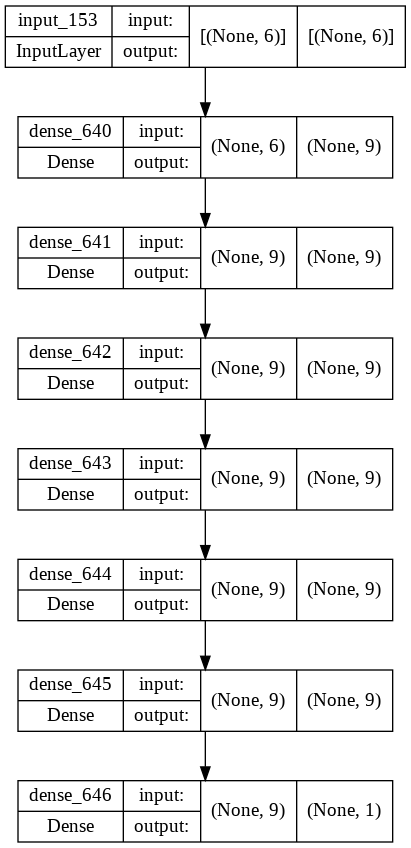

In [23]:
# Visualized the summary of the "Best" model
tf.keras.utils.plot_model(best_model, show_shapes = True)

### Network Network Model Testing

In [24]:
# Testing Data Case
s = 150 # Stock Price
k = 50 # Strike
v = 0.3 # Volatility
r = 0.02 # Interest Rate
d = 0 # Dividend
t = 0.5 # Time to Maturity

In [25]:
# Create a DataFrame for test Data
test_data = pd.DataFrame({"Price":s,"Strike":k,"Volatility":v,"Interst Rate":r,"Dividend":d,"Time":t}, index=[0])

In [26]:
# Standardise the features with train StandardScaler()
x_test_standard = pd.DataFrame(standardscaler.transform(test_data), columns = test_data.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Interst Rate
- Price
- Volatility
Feature names seen at fit time, yet now missing:
- Interest Rate
- Stock
- Volatiltiy

  warnings.warn(message, FutureWarning)


In [27]:
# Neural Network Fair Value
NN_best_predict = float(best_model.predict(x_test_standard))
print(NN_best_predict)

758.5599975585938


## Alternative Pricing Method (Binomial Tree and Monte Carlo Simulation)

### Binomial Tree Method

In [28]:
# nCr Function
def nCr(n,r):
    return math.factorial(n) / (math.factorial(r)*math.factorial(n-r))

In [29]:
# Variable for later use
obvservation = 252 # Daily observation 

n_step = t*obvservation  # no of time step 
dt = 1/obvservation # delta time change observation
up = np.exp(v*np.sqrt(dt)) # stock price change if up
down = 1/up # stock price change if down
pu = (np.exp(r*dt) - down)/(up-down) # probabilty of stock price goes up 
pd = 1 - pu # probabilty of stock price goes down\

In [30]:
Tree_PV = 0 # Expected Present Fair Value

# Loop to calculate all the scenarios under the binomial tree (Alternative, recursive method)
for iter in range(int(n_step+1)):
# terminal value and probabilty weighted 
  ST = s* (up**iter) * (down**(n_step-iter))
  Tree_PV = Tree_PV + max((ST-k),0) * nCr(n_step,iter) * (pu**iter) * (pd**(n_step-iter)) * np.exp(-r*t)

In [31]:
# Binomial Tree Simulation Fair Value
print(Tree_PV)

100.49750846473319


### Monte Carlo Simulation

In [32]:
# A list of random numbers drawn from the standard normal distribution for simulation purposes.
n = 1000000 # number of rnd generate
np.random.seed(0) # Ensure repeatibility
rnd_list = np.random.normal(0, 1, n) # rnd list


In [33]:
MC_FV = 0 # Expected Present Fair Value
# Monte Carlo Simulation
for rnd in rnd_list:
  # No early exercise behavior, EU style
  ST = s*np.exp((r-d-0.5*v*v)*t+v*rnd*np.sqrt(t))
  MC_FV = MC_FV + max((ST - k),0)*np.exp(-r*t)

# expected Fair Value
MC_PV = MC_FV/n

In [34]:
# Monte Carlo Simulation Fair Value
print(MC_PV)

100.54477855258584


### Huston Model

In [35]:
# https://www.maths.univ-evry.fr/pages_perso/crepey/Finance/051111_mikh%20heston.pdf

# Huston characteristic Function 
def characteristic_function(underlying, kappa, lambd, rho, sigma, theta, phi, tau, r0, q0, v0, s0):

    if underlying == 1:
        u = 0.5
        b = kappa + lambd - rho*sigma
    else:
        u = -0.5
        b = kappa + lambd 

    a = kappa*theta
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + sigma*sigma*(2*u*phi*1j+phi**2))
    g = (b - rho*sigma*phi*1j + d)/(b - rho*sigma*phi*1j - d)

    C = (r0 - q0)*phi*1j*tau + (a/(sigma**2))*((b - rho*sigma*phi*1j + d)*tau - 2*np.log((1 - g*np.exp(d*tau))/(1 - g)))
    D = ((b - rho*sigma*phi*1j + d)/(sigma**2))*((1 - np.exp(d*tau))/(1 - g*np.exp(d*tau)))

    return np.exp(C + D*v0 + 1j*phi*s0)

In [36]:
# Porbability defined via the inverse Fourier transformation Function
def p_j (K0, underlying, kappa, lambd, rho, sigma, theta, tau, r0, q0, v0, s0):
  integral = lambda phi: np.real((np.exp(-1j*phi*np.log(K0))) * characteristic_function(underlying, kappa, lambd, rho, sigma, theta, phi, tau, r0, q0, v0, s0)/(1j*phi))
  return (0.5 + (1/np.pi)*quad(integral,0,100)[0])

In [37]:
# Huston call solution Function
def heston_call(K0, kappa, lambd, rho, sigma, theta, tau, r0, q0, v0, s0):
    p1 = p_j(K0, 1, kappa, lambd, rho, sigma, theta, tau, r0, q0, v0, s0)
    p2 = p_j(K0, 2, kappa, lambd, rho, sigma, theta, tau, r0, q0, v0, s0)
    return (s0*p1-K0*np.exp(-(r0-q0)*tau)*p2)

In [38]:
# Reduced data set, faster processing (illustrative examples)
df_Huston = df[0:11]

In [39]:
# optimization
def SqErr(x, data_frame):

    kappa, lambd, rho, sigma, theta, v0 = x
    error = 0.0

    for i in range(0,len(data_frame)):
      s0 = data_frame["Stock"].to_numpy('float')[i]
      r0 = data_frame["Interest Rate"].to_numpy('float')[i]
      q0 = data_frame["Dividend"].to_numpy('float')[i]
      K0 = data_frame["Strike"].to_numpy('float')[i]
      tau = data_frame["Time"].to_numpy('float')[i]
      Call_Price = data_frame["Call"].to_numpy('float')[i]
      heston_price = heston_call(K0, kappa, lambd, rho, sigma, theta, tau, r0, q0, v0, s0)
      error += (heston_price - Call_Price)**2
    return error

# Initialize
initial_value = [2, 0.02, 0, 0.2, 0.02, 0.5] # kappa, lambd, rho, sigma, theta, v0

optimization = minimize(SqErr, initial_value, args = (df_Huston) , tol = 1e-3, method = 'SLSQP', options = {'maxiter': 100})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.


In [40]:
# optimization
optimization_input = optimization.x
huston_PV = heston_call(K0 = k, kappa = optimization_input[0], lambd = optimization_input[1], rho = optimization_input[2], sigma = optimization_input[3], theta = optimization_input[4], tau = t, r0 = r, q0 = d, v0 = optimization_input[5], s0 = s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.


In [41]:
# Huston Fair Value
print(huston_PV)

100.49257989016226


### BSM Closed Form

In [42]:
# BSM EU Call Closed Form Solution
d1 = (np.log(s/k) + (r-d+0.5*v*v))/(v*np.sqrt(t))
d2 = d1 - v*np.sqrt(t)
BSM_PV = s*np.exp(-d*t)*norm.cdf(d1)-k*np.exp(-r*t)*norm.cdf(d2)

In [43]:
# BSM Closed Form Fair Value
print(BSM_PV)

100.49750853563042


## Unit Test

In [44]:
# unit test, no, 4, 3, 2 and 1 decmials rounding
class TestOption(unittest.TestCase):
    
    def setUp(self):
        pass

    def tearDown(self):
        pass

    def test1_1_no_rounding_Tree(self):
      self.assertEqual(Tree_PV, BSM_PV)

    def test1_2_4f_rounding_Tree(self):
      self.assertEqual(round(Tree_PV,4), round(BSM_PV,4))

    def test1_3_3f_rounding_Tree(self):
      self.assertEqual(round(Tree_PV,3), round(BSM_PV,3))

    def test1_4_2f_rounding_Tree(self):
      self.assertEqual(round(Tree_PV,2), round(BSM_PV,2))

    def test1_5_1f_rounding_Tree(self):
      self.assertEqual(round(Tree_PV,1), round(BSM_PV,1))



    def test2_1_no_rounding_MC(self):
      self.assertEqual(MC_PV, BSM_PV)
  
    def test2_2_4f_rounding_MC(self):
      self.assertEqual(round(MC_PV,4), round(BSM_PV,4))

    def test2_3_3f_rounding_MC(self):
      self.assertEqual(round(MC_PV,3), round(BSM_PV,3))

    def test2_4_2f_rounding_MC(self):
      self.assertEqual(round(MC_PV,2), round(BSM_PV,2))

    def test2_5_1_1f_rounding_MC(self):
      self.assertEqual(round(MC_PV,1), round(BSM_PV,1))



    def test3_1_2_no_rounding_NN(self):
      self.assertEqual(NN_best_predict, BSM_PV)    

    def test3_2_4f_rounding_NN(self):
      self.assertEqual(round(NN_best_predict,4), round(BSM_PV,4))

    def test3_3_3f_rounding_NN(self):
      self.assertEqual(round(NN_best_predict,3), round(BSM_PV,3))

    def test3_4_2f_rounding_NN(self):
      self.assertEqual(round(NN_best_predict,2), round(BSM_PV,2))

    def test3_5_1f_rounding_NN(self):
      self.assertEqual(round(NN_best_predict,1), round(BSM_PV,1))



    def test4_1_2_no_rounding_heston(self):
      self.assertEqual(huston_PV, BSM_PV)    

    def test4_2_4f_rounding_heston(self):
      self.assertEqual(round(huston_PV,4), round(BSM_PV,4))

    def test4_3_3f_rounding_heston(self):
      self.assertEqual(round(huston_PV,3), round(BSM_PV,3))

    def test4_4_2f_rounding_heston(self):
      self.assertEqual(round(huston_PV,2), round(BSM_PV,2))

    def test4_5_1f_rounding_heston(self):
      self.assertEqual(round(huston_PV,1), round(BSM_PV,1))



    def test4_1_nCe(self):
      self.assertEqual(nCr(10,2), 45)
      self.assertEqual(nCr(0,0), 1)
      self.assertEqual(nCr(7,5), 21)
      self.assertEqual(nCr(2,1), 2)

unittest.main(argv=['first-arg-is-ignored'], exit=False)

F....FFFF.FFFFFF.FFF.
FAIL: test1_1_no_rounding_Tree (__main__.TestOption)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-44-7a4635ad8a8a>", line 11, in test1_1_no_rounding_Tree
    self.assertEqual(Tree_PV, BSM_PV)
AssertionError: 100.49750846473319 != 100.49750853563042

FAIL: test2_1_no_rounding_MC (__main__.TestOption)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-44-7a4635ad8a8a>", line 28, in test2_1_no_rounding_MC
    self.assertEqual(MC_PV, BSM_PV)
AssertionError: 100.54477855258584 != 100.49750853563042

FAIL: test2_2_4f_rounding_MC (__main__.TestOption)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-44-7a4635ad8a8a>", line 31, in test2_2_4f_rounding_MC
    self.assertEqual(round(MC_PV,4), round(BSM_PV,4))
AssertionError: 100.5448 != 